In [ ]:
!pip install kaggle
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/


!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Download dataset

!kaggle competitions download -c playground-series-s3e7


playground-series-s3e7.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#unzip file 

!unzip playground-series-s3e7


Archive:  playground-series-s3e7.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [ ]:
#imports
from time import time
import datetime 
from lightgbm import early_stopping


import math
import matplotlib
import matplotlib as mpl
import matplotlib.cm as cmap
import matplotlib.colors as mpl_colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import lightgbm as lgbm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import warnings
from cycler import cycler
from matplotlib.ticker import MaxNLocator


# import csv data in respective dataframes
train_df = pd.read_csv('/content/train.csv', index_col=0)
test_df = pd.read_csv('/content/test.csv', index_col=0)


In [ ]:
train_df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
id,,,,,,,,,,,,,,,,,,
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42095,3,0,0,4,0,0,1,160,2018,12,30,1,0,0,0,140.00,2,1
42096,2,0,0,3,0,0,0,34,2017,9,23,0,0,0,0,224.67,0,0
42097,2,0,0,2,2,0,0,292,2018,7,21,0,0,0,0,96.00,0,0


In [ ]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_adults,42100.0,1.920713,0.524950,0.0,2.0,2.00,2.0,4.0
no_of_children,42100.0,0.141093,0.450128,0.0,0.0,0.00,0.0,9.0
no_of_weekend_nights,42100.0,0.884632,0.885693,0.0,0.0,1.00,2.0,7.0
no_of_week_nights,42100.0,2.398005,1.427330,0.0,1.0,2.00,3.0,17.0
type_of_meal_plan,42100.0,0.239192,0.587674,0.0,0.0,0.00,0.0,3.0
required_car_parking_space,42100.0,0.025249,0.156884,0.0,0.0,0.00,0.0,1.0
room_type_reserved,42100.0,0.428931,0.832605,0.0,0.0,0.00,1.0,6.0
lead_time,42100.0,103.888029,81.069343,0.0,37.0,93.00,155.0,443.0
arrival_year,42100.0,2017.856295,0.350795,2017.0,2018.0,2018.00,2018.0,2018.0
arrival_month,42100.0,7.593539,2.829395,1.0,6.0,8.00,10.0,12.0


In [ ]:
train_df.isnull().values.any()

False

In [ ]:
train_df.isna().values.any()

False

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42100 entries, 0 to 42099
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          42100 non-null  int64  
 1   no_of_children                        42100 non-null  int64  
 2   no_of_weekend_nights                  42100 non-null  int64  
 3   no_of_week_nights                     42100 non-null  int64  
 4   type_of_meal_plan                     42100 non-null  int64  
 5   required_car_parking_space            42100 non-null  int64  
 6   room_type_reserved                    42100 non-null  int64  
 7   lead_time                             42100 non-null  int64  
 8   arrival_year                          42100 non-null  int64  
 9   arrival_month                         42100 non-null  int64  
 10  arrival_date                          42100 non-null  int64  
 11  market_segment_

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
features = test1.columns.tolist()

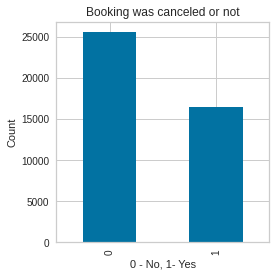

In [ ]:
ax = train_copy[conf.target].value_counts().plot.bar(figsize=(4, 4), legend=False)
ax.set_title('Booking was canceled or not')
ax.set_xlabel('0 - No, 1- Yes')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

ValueError: ignored

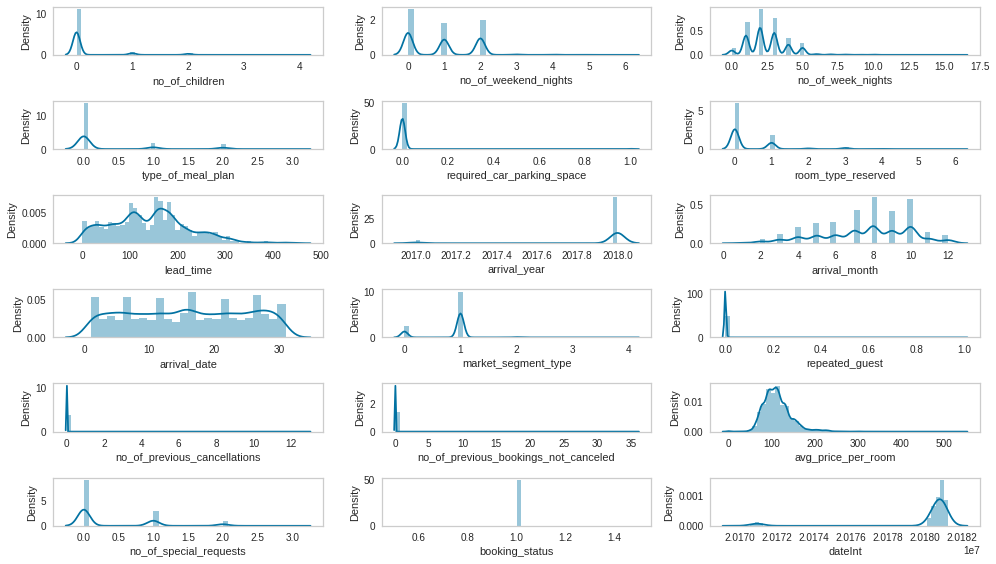

In [ ]:
plt.figure(figsize=(14,8))
temp = train_copy[train_copy.booking_status == 1]
for i, col in enumerate(list(temp.iloc[:,1:].columns.values)):
    plt.subplot(6,3,i+1)
    sns.distplot(temp[col], color='b', kde=True)
    plt.grid()
    plt.tight_layout()

In [ ]:
combine_date = ['arrival_year', 'arrival_month', 'arrival_date']

In [ ]:
train_copy['combine_date'] = train1[combine_date].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)

In [ ]:
#we are combining the dates of from the data and combining the day/month/year, 
#we found that there were discrepancies in the training dataset since many of 
#the number of days were not aligninig with the months. 
import datetime
for index, row in train_df.iterrows():
  year=int(row['arrival_year'])
  month=int(row['arrival_month'])
  day=int(row['arrival_date'])
  try:
   datetime.datetime(year=year,month=month,day=day)
  except ValueError:
    print (index)
    print (year,month,day)
    train_df=train_df.drop(index)
train_df['dateInt']=train_df['arrival_year'].astype(str) + train_df['arrival_month'].astype(str).str.zfill(2)+ train_df['arrival_date'].astype(str).str.zfill(2)
train_df['combineDate'] = pd.to_datetime(train_df['dateInt'], format='%Y%m%d')
train_df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,dateInt,combineDate
id,,,,,,,,,,,,,,,,,,,,
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0,20180114,2018-01-14
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0,20180729,2018-07-29
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0,20181202,2018-12-02
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0,20181201,2018-12-01
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1,20181016,2018-10-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42095,3,0,0,4,0,0,1,160,2018,12,30,1,0,0,0,140.00,2,1,20181230,2018-12-30
42096,2,0,0,3,0,0,0,34,2017,9,23,0,0,0,0,224.67,0,0,20170923,2017-09-23
42097,2,0,0,2,2,0,0,292,2018,7,21,0,0,0,0,96.00,0,0,20180721,2018-07-21


In [ ]:
train_df['combineDate'] = pd.to_datetime(train_df['combineDate'])

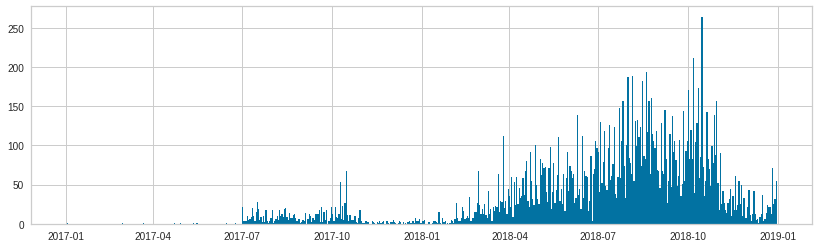

In [ ]:
train_df[train_df.booking_status==1]['combineDate'].hist(figsize=(14, 4), bins=train_df['combineDate'].unique().shape[0])

In [ ]:
booking_cancel = train_df[train_df.booking_status==1]['combineDate'].value_counts()
booking_not_cancel= train_df[train_df.booking_status==0]['combineDate'].value_counts()

In [ ]:
temp = pd.DataFrame({
    "booking_cancel" : booking_cancel.values    
},
index = booking_cancel.index)

temp2 = pd.DataFrame({
    "booking_not_cancel" : booking_not_cancel.values    
},
index = booking_not_cancel.index)
booking_canceled_or_not = pd.concat([temp, temp2], axis=1).fillna(0)
booking_canceled_or_not

,booking_cancel,booking_not_cancel
2017-01-02,1.0,0.0
2017-01-18,0.0,1.0
2017-01-19,0.0,2.0
2017-01-27,0.0,1.0
2017-02-06,0.0,1.0
...,...,...
2018-12-27,29.0,165.0
2018-12-28,25.0,57.0
2018-12-29,32.0,81.0
2018-12-30,34.0,104.0


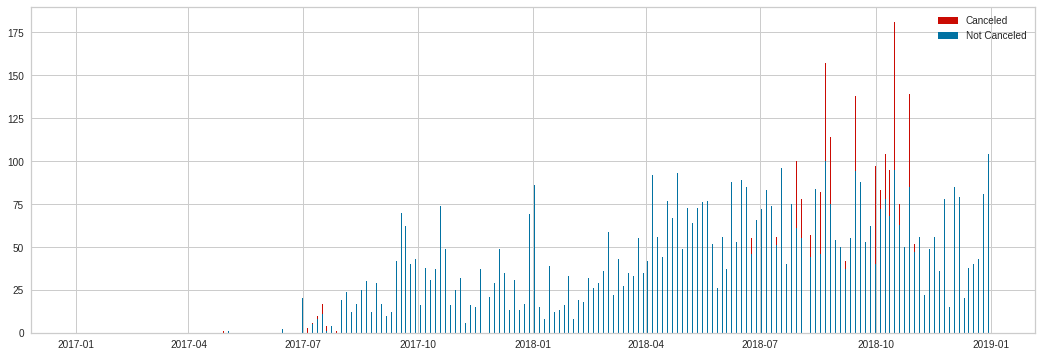

In [ ]:
#https://stackoverflow.com/questions/14270391/python-matplotlib-multiple-bars
fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(booking_canceled_or_not.index, booking_canceled_or_not['booking_cancel'], width=0.2, color='r', align='center', label='Canceled')
ax.bar(booking_canceled_or_not.index, booking_canceled_or_not['booking_not_cancel'], width=0.2, color='b', align='center', label='Not Canceled')
ax.xaxis_date()
#ax.autoscale(tight=True)
ax.legend(loc="best")
fig.show()


In [ ]:
from sklearn.feature_selection import mutual_info_classif

In [ ]:
train_copy = train_df.copy()
test_copy = test_df.copy()

In [ ]:
#Feature selection
#Mutual information: Measures the dependency between the variables

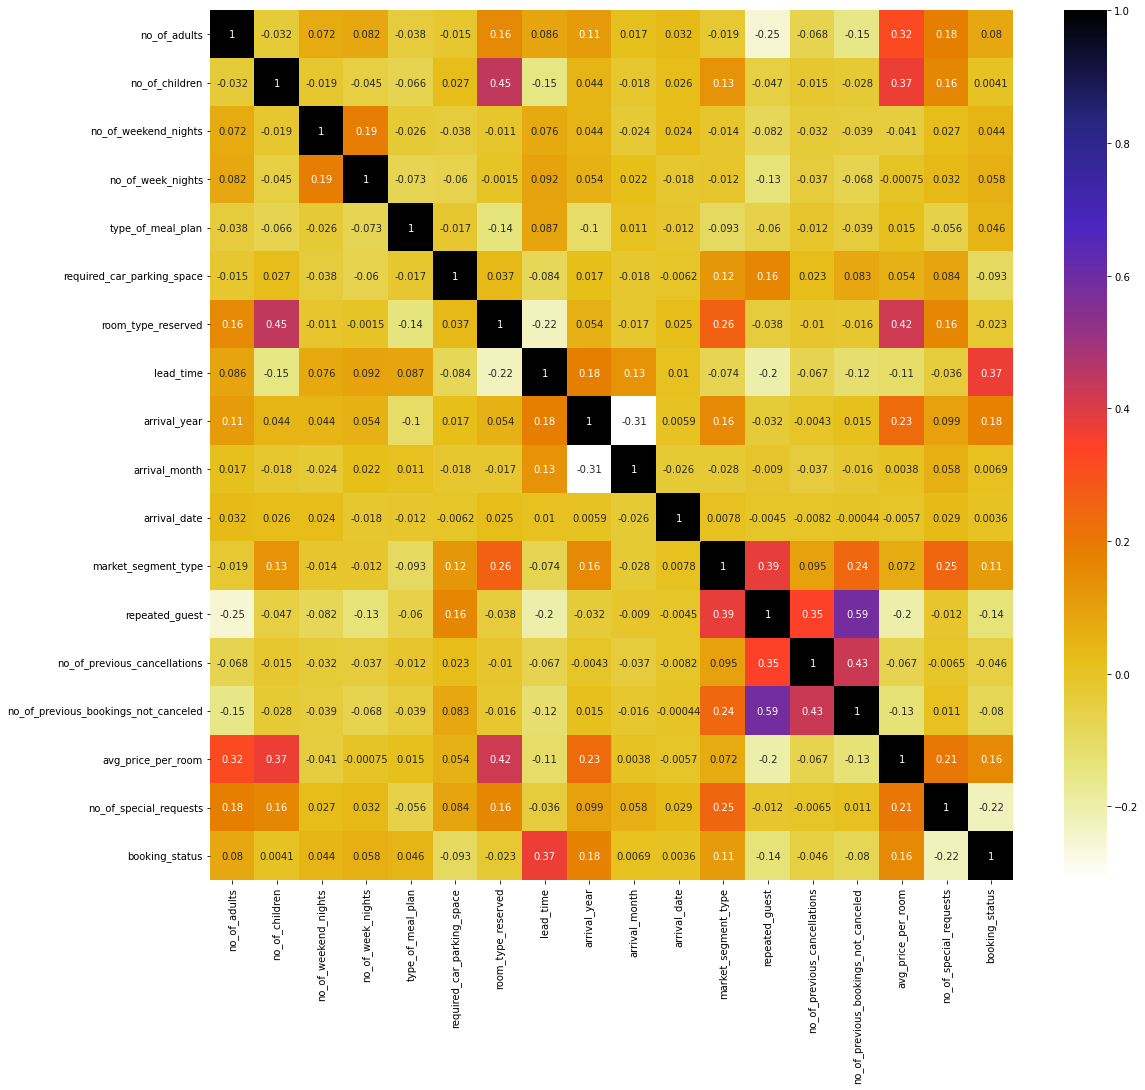

In [ ]:
plt.figure(figsize=(18,16))
sns.heatmap(train_df.corr(), annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [ ]:
cor= train_df.corr()['booking_status']
cor

no_of_adults                            0.079520
no_of_children                          0.004070
no_of_weekend_nights                    0.044274
no_of_week_nights                       0.058260
type_of_meal_plan                       0.045929
required_car_parking_space             -0.093285
room_type_reserved                     -0.023378
lead_time                               0.374908
arrival_year                            0.178666
arrival_month                           0.006879
arrival_date                            0.003594
market_segment_type                     0.112657
repeated_guest                         -0.136015
no_of_previous_cancellations           -0.045643
no_of_previous_bookings_not_canceled   -0.080189
avg_price_per_room                      0.157244
no_of_special_requests                 -0.220412
booking_status                          1.000000
Name: booking_status, dtype: float64

In [ ]:
!pip3 install -U lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import plotly.express as px

from sklearn.model_selection import train_test_split

from lazypredict.Supervised import LazyClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_df['combineDate'] = pd.to_datetime(train_df['combineDate']).astype('int64')


X = train_df.drop('booking_status', axis=1 )
y = train_df['booking_status']
X_train , X_test , y_train , y_test = train_test_split(X , 
                                                       y, 
                                                       random_state = 12 ,
                                                       test_size =0.33)

X_train = X_train.drop('dateInt', axis=1)
X_test = X_test.drop('dateInt', axis=1)

In [ ]:
#running LGBM regression model
from lightgbm import LGBMRegressor, LGBMClassifier, Booster

model = LGBMClassifier(n_estimators = 150, learning_rate = 0.1)
model.fit(X_train, y_train)
preds = model.predict(X_test)
model.score(X_test, y_test)

0.8197737263097211

In [ ]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import xgboost as xgb

# Create an XGBoost classifier object
clf = xgb.XGBClassifier()

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.8088203502197882


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier object
clf = RandomForestClassifier(n_estimators=100, max_depth=5)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.7976507890754486


ValueError: ignored

In [ ]:
sub = pd.read_csv('/content/sample_submission.csv',index_col='id')
sub.booking_status = pred
sub.to_csv("submission.csv")
sub.head()


NameError: ignored